## Robot programming workshop 07

<div class="alert alert-block alert-info">For this workshop you will be using the dr20 robot and a new environment, a more complex 'maze' with straight lines and sign posts, 02_Maze_scene_vrep.ttt, that we can use to further test the dr20's array of sensors including its front facing camera. The goal of this workshop is to interface with the robot class and write some code to pilot the robot around the 'maze' to take photos of the sign posts at each junction. <i>We will then hopefully be able to use these photos to later train a simple neural network towards helping to solve the maze in a later workshop.</i> Make sure you have save sim.py, simConst.py (or vrepConst.py) and remoteApi.dll files to a directory and also downloaded the <b>02_Maze_scene_vrep.ttt</b> to your working folder (a known location)</div>

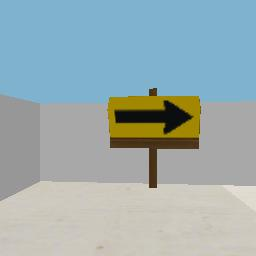

<font color="red"><b>Task 1:</b></font> Download the <b>short_path_vrep.ttt</b> to a working directory where you have saved sim.py, simConst.py (or vrepConst.py) and remoteApi.dll and change your path to that directory.  

In [ ]:
import os
# set this path to your working folder
desiredPath = "C:\\Users\\2220205\\OneDrive - University of Wolverhampton\\Desktop\\Robotics\\Robotics\\Files" 
os.chdir(desiredPath)
print("Current working directory: {}".format(os.getcwd()))   # sanity check

try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import sys
# used for the camera data
import numpy as np
from PIL import Image
import csv

if os.path.isfile('/'.join([desiredPath, 'vrepConst.py'])):
    import vrepConst as wlvConst
else:
    import simConst as wlvConst

<font color="red"><b>Task 2:</b></font> Just a test that the PIL image library is working and we can display images on our machine.  The show method should launch a default viewer on your system and display the image.  

In [ ]:
# Location of the image
img = Image.open("pepper.jpg")

img.show()

<font color="red"><b>Task 3:</b></font> The following is our instance of the Dr20Robot which will initialise the camera sensor and add code to capture an image (allowing the robot to 'see') and conduct some post processing to record the information in the image.  Note: we need to use this version of the camera handing code as the code for this in the base class does not work.  

In [ ]:
from Dr20Robot import Dr20Robot_Interface

class Dr20Robot(Dr20Robot_Interface):

    def __init__(self, sim, clientID):
        Dr20Robot_Interface.__init__(self, sim, clientID)
        errCode, self.cameraSensor = sim.simxGetObjectHandle(clientID, "Vision_sensor", sim.simx_opmode_oneshot_wait )
        if errCode > 0:
            print("*** Error getting initialising the camera {}".format(errCode))
        returnCode,resolution,raw_image=sim.simxGetVisionSensorImage(clientID, self.cameraSensor, 0,sim.simx_opmode_streaming)

    def robotBehaviour(self):
        sensReading = self.readSensors()
        front_left = sensReading[0]
        front = sensReading[2]
        front_right = sensReading[3]
        rear_left = sensReading[1]
        rear_right = sensReading[4]


        self.move_forward(0.2)
        if front < 0.2:
            self.stop()
            time.sleep(1)
            image = self.camera_image()
            self.processImage(image)
            self.stop()
            if rear_left > rear_right:
                self.rotate_left(0.2)
                time.sleep(3)
                self.stop()
                self.move_forward(0.2)
            elif rear_left < 1 and rear_right < 0.6:
                self.rotate_right(0.2)
                time.sleep(3)
                self.stop()
                self.move_forward(0.2)
            elif rear_left < 0.5:
                self.rotate_right(0.2)
                time.sleep(3)
                self.stop()
                self.move_forward(0.2)
            elif rear_right < 0.5:
                self.rotate_left(0.2)
                time.sleep(3)
                self.stop()
                self.move_forward(0.2)
            elif rear_right <= 1 and rear_left <= 1:
                self.rotate_left(0.2)
                time.sleep(3)
                self.stop()
                self.move_forward(0.2)
        
        
    def processImage(self, array_raw):
        (h, w, d) = array_raw.shape
        print("width={}, height={}, depth={}".format(w, h, d))
        array = array_raw[::-1]

        if False: 
            list_columns = ['R', 'G', 'B'] 
            np_array_col = np.array(list_columns)
            with open('data1.csv', 'w') as csvfile:
                write = csv.writer(csvfile)
                write.writerow(np_array_col)
                write.writerows(array)

        img = Image.fromarray(array)
        if True: 
            img.save("image.jpg")
        if True:
            img.show()

        
    def camera_image(self):
        returnCode,resolution,raw_image=self._sim.simxGetVisionSensorImage(self.clientID, self.cameraSensor, 0,self._sim.simx_opmode_streaming)
        time.sleep(0.2)
        returnCode,resolution,raw_image=self._sim.simxGetVisionSensorImage(self.clientID, self.cameraSensor, 0,self._sim.simx_opmode_buffer)
        image = np.array(raw_image).astype(np.uint8)
        if False: 
            print(returnCode)
            print(resolution)
            print(len(raw_image))
        image.resize([resolution[0],resolution[0],3])
        return image

<font color="red"><b>Task 4:</b></font> Connects to the simulator, creates the robot, sets it to run, and closes the network connection once the robot is done.  

In [ ]:
def mazeRobotTest():
    print ('Program started')
    sim.simxFinish(-1) 

    clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to CoppeliaSim

    if clientID != -1:
        print ('Connected to remote API server')
    else:
        print('Connection failed!!')
        sys.exit('Could not connect')

    bot = Dr20Robot(sim, clientID)
    bot.robotBehaviour()
    time1 = time.time()
    bot.stop()
    time.sleep(1)
    bot.rotate_right(0.2)
    time.sleep(0.1)
 
    while time.time() - time1 < 1000000:
        bot.robotBehaviour()
            
        
    bot.stop()
    time.sleep(0.5)    
    sim.simxFinish(-1) 
    print("...done")

<font color="red"><b>Task 5:</b></font> Run the V-rep/CoppeliaSim Dr20 robot  (remember to also run the scene) and read the sensor data. <b>Note: the processImage function blocks/halts the program waiting for the image window to be closed before proceeding</b> 

In [ ]:
try:
    mazeRobotTest()
except Exception as ex:
    print("Exception was: {}".format(ex))
    sim.simxFinish(-1) ## just in case, close all opened connections
    print("...uh oh, something went wrongt!!!")

<font color="red"><b>Task 6:</b></font> For this workshop you will be navigating the maze.  At each junction (before the robot takes a left, right or about turn) your robot should take a picture of the sign and save the image to a file. Your robot can stop after taking <b>10 images</b>, <i>(there are about 25 signs in the scene to choose from).  You may use the cells below for your solution and/or edit the code in <b>task 3</b> above</i>.<br><br><b>Note:</b>  Your robot's behaviour should be general and autonomous, ie. based on the robot's sensor readings to decide where to turn, marks will be deducted if you merely feed a sequence of turn instructions for the robot to follow.       

<div class="alert alert-block alert-danger">That is the end for this workbook. When you shutdown CoppeliaSim it will offer you the opportunity to save changes, select <b>No</b>. And remember to save your workbook before you shutdown. Next week: The final section on this introduction to writing code for robotics. </div>